# **The Problem & Business Importance**





# **Data Identification & Analysis**

In [115]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib

from KNN_D import KNN_D
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,train_test_split , KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

In [116]:
df = pd.read_csv('i4talent_dataset.csv')
df['datum'] = pd.to_datetime(df['datum'])
df['geboortedatum'] = pd.to_datetime(df['geboortedatum'])
df['indiensttreding_datum'] = pd.to_datetime(df['indiensttreding_datum'])


In [117]:
df.head()

,WerknemerID,datum,geboortedatum,indiensttreding_datum,uitdiensttreding_datum,leeftijd,lengte_dienst,stad,afdeling,klant_id,geslacht_id,geslacht,uitdiensttreding_reden,uitdiensttreding_type,STATUS_JAAR,STATUS,BUSINESS_UNIT
0,6962,2018-12-31 05:06:00,1989-06-26 05:06:00,2013-05-23 05:06:00,1905-01-01 05:06:00,29.0,5.0,Amstelveen,BI,30,V,Vrouw,Niet van toepassing,Niet van toepassing,2018,Actief,Detachering
1,6212,2016-12-30 05:06:00,1983-08-25 05:06:00,2010-04-24 05:06:00,1905-01-01 05:06:00,33.0,6.0,Utrecht,Accountant,21,M,Man,Niet van toepassing,Niet van toepassing,2016,Actief,Detachering
2,5325,2018-12-31 05:06:00,1976-04-24 05:06:00,2006-06-09 05:06:00,1905-01-01 05:06:00,42.0,12.0,Amsterdam,BI,42,V,Vrouw,Niet van toepassing,Niet van toepassing,2018,Actief,Detachering
3,8193,2018-12-31 05:06:00,1998-10-26 05:06:00,2018-04-28 05:06:00,1905-01-01 05:06:00,20.0,NaN,Utrecht,BI,21,V,Vrouw,Niet van toepassing,Niet van toepassing,2018,Actief,Detachering
4,5926,2013-12-31 05:06:00,1981-03-19 05:06:00,2009-01-09 05:06:00,1905-01-01 05:06:00,32.0,4.0,Den Haag,Accountant,18,M,Man,Niet van toepassing,Niet van toepassing,2013,Actief,Detachering


In [118]:
df.describe()

,WerknemerID,datum,geboortedatum,indiensttreding_datum,leeftijd,lengte_dienst,klant_id,STATUS_JAAR
count,49753.000000,49753,49753,49753,44653.000000,44802.000000,49753.000000,49753.000000
mean,4859.473600,2016-08-06 00:21:52.006914304,1974-01-10 05:10:34.379434400,2005-09-04 11:13:13.710530176,42.046223,10.442592,27.296525,2015.612566
min,1318.000000,2011-01-01 05:06:00,1946-01-15 05:06:00,1994-08-28 05:06:00,19.000000,0.000000,1.000000,2011.000000
25%,3360.000000,2013-12-31 05:06:00,1963-05-28 05:06:00,2000-06-01 05:06:00,31.000000,5.000000,16.000000,2013.000000
50%,5031.000000,2016-12-30 05:06:00,1973-12-04 05:06:00,2005-03-31 05:06:00,42.000000,10.000000,28.000000,2016.000000
75%,6335.000000,2018-12-31 05:06:00,1984-07-17 05:06:00,2010-10-13 05:06:00,53.000000,15.000000,42.000000,2018.000000
max,8336.000000,2020-12-30 05:06:00,1999-12-31 05:06:00,2018-12-11 05:06:00,65.000000,26.000000,46.000000,2020.000000
std,1827.113618,NaN,NaN,NaN,12.424199,6.326893,13.512861,2.845621


In [119]:
print(df.isna().sum())

WerknemerID                  0
datum                        0
geboortedatum                0
indiensttreding_datum        0
uitdiensttreding_datum       0
leeftijd                  5100
lengte_dienst             4951
stad                      5543
afdeling                  5065
klant_id                     0
geslacht_id                  0
geslacht                     0
uitdiensttreding_reden       0
uitdiensttreding_type        0
STATUS_JAAR                  0
STATUS                       0
BUSINESS_UNIT                0
dtype: int64


In [120]:
df['leeftijd'] = df['leeftijd'].fillna((df['datum'] - df['geboortedatum']).dt.days // 365)
df['lengte_dienst'] = df['lengte_dienst'].fillna((df['datum'] - df['indiensttreding_datum']).dt.days // 365)

print(df.isna().sum())

WerknemerID                  0
datum                        0
geboortedatum                0
indiensttreding_datum        0
uitdiensttreding_datum       0
leeftijd                     0
lengte_dienst                0
stad                      5543
afdeling                  5065
klant_id                     0
geslacht_id                  0
geslacht                     0
uitdiensttreding_reden       0
uitdiensttreding_type        0
STATUS_JAAR                  0
STATUS                       0
BUSINESS_UNIT                0
dtype: int64


In [121]:
df_sort = df.sort_values(by=['WerknemerID', 'datum'])
# filling in the missing values based on values that where put first.
df_sort['stad'] = df_sort.groupby('WerknemerID')['stad'].ffill()
most_common_value = df_sort['stad'].mode()[0]  
df_sort['stad'] = df_sort['stad'].fillna(most_common_value)

df_sort['afdeling'] = df_sort.groupby('WerknemerID')['afdeling'].ffill()
most_common_value_2 = df_sort['afdeling'].mode()[0]  
df_sort['afdeling'] = df_sort['afdeling'].fillna(most_common_value_2)


In [122]:
df_sort = df_sort.sort_values(by='datum', ascending=False)
df_sort = df_sort.drop_duplicates(subset='WerknemerID', keep='first')
df_sort.count()

WerknemerID               6284
datum                     6284
geboortedatum             6284
indiensttreding_datum     6284
uitdiensttreding_datum    6284
leeftijd                  6284
lengte_dienst             6284
stad                      6284
afdeling                  6284
klant_id                  6284
geslacht_id               6284
geslacht                  6284
uitdiensttreding_reden    6284
uitdiensttreding_type     6284
STATUS_JAAR               6284
STATUS                    6284
BUSINESS_UNIT             6284
dtype: int64

In [123]:
columns_to_delete = ['geboortedatum', 'WerknemerID', 'uitdiensttreding_datum', 'indiensttreding_datum', 'geslacht', 'uitdiensttreding_type', 'datum', 'STATUS_JAAR', 'uitdiensttreding_reden']
df_new = df_sort.drop(columns=columns_to_delete)


In [124]:
df_with_dummies = pd.get_dummies(df_new, columns=['stad', 'afdeling', 'geslacht_id', 'STATUS', 'BUSINESS_UNIT'], drop_first=True , dtype = int)


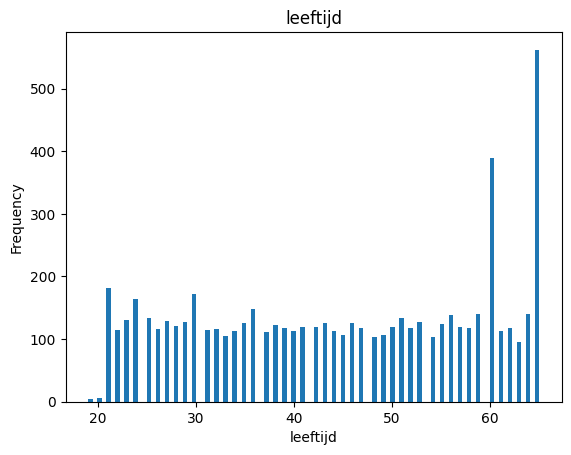

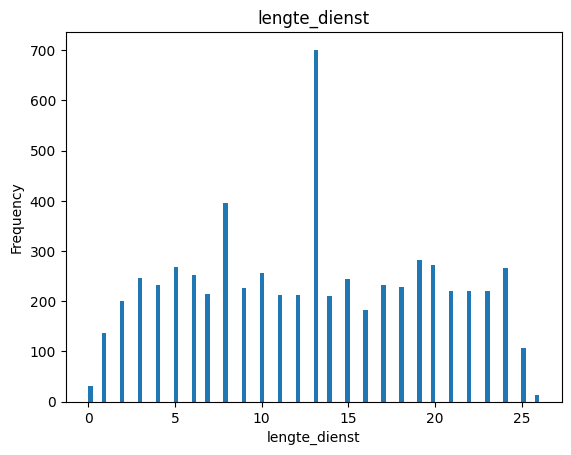

In [125]:
columns_numerical_with_nas = ['leeftijd', 'lengte_dienst']
for col in columns_numerical_with_nas:
    plt.hist(df_sort[col], bins=100)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

geboortedatum, WerknemerID, uitdiensttreding_datum, indiensttreding_datum, geslacht, uitdiensttreding_type

Dummies: 'stad', 'afdeling', 'geslachtID', 'uitdiensttreding_reden', 'Status', 'BUSINESS_UNIT'

In [126]:
#Used later for model evaluation
model_scores = {}

#You can download the pretrained models here : https://github.com/dvanaanhout/GROUP5
#Saves time running the file.

In [127]:
X = df_with_dummies.drop(columns=['STATUS_Beëindigd'])
y = df_with_dummies['STATUS_Beëindigd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [128]:

saved_model_name = 'model_lr.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_lr = loaded_model
else:
    model_lr = LogisticRegression()
    model_lr.fit(X_train, y_train)
    joblib.dump(model_lr, saved_model_name)

y_pred = model_lr.predict(X_test)

train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)


model_scores['Logistic Regression'] = {
    'Train Score': train_score,
    'Test Score': test_score
}


conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print(classification_report(y_test, y_pred))



Train Score: 0.7680525164113785
Test Score: 0.766109785202864
Confusion Matrix:
[[958   0]
 [294   5]]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       958
           1       1.00      0.02      0.03       299

    accuracy                           0.77      1257
   macro avg       0.88      0.51      0.45      1257
weighted avg       0.82      0.77      0.67      1257



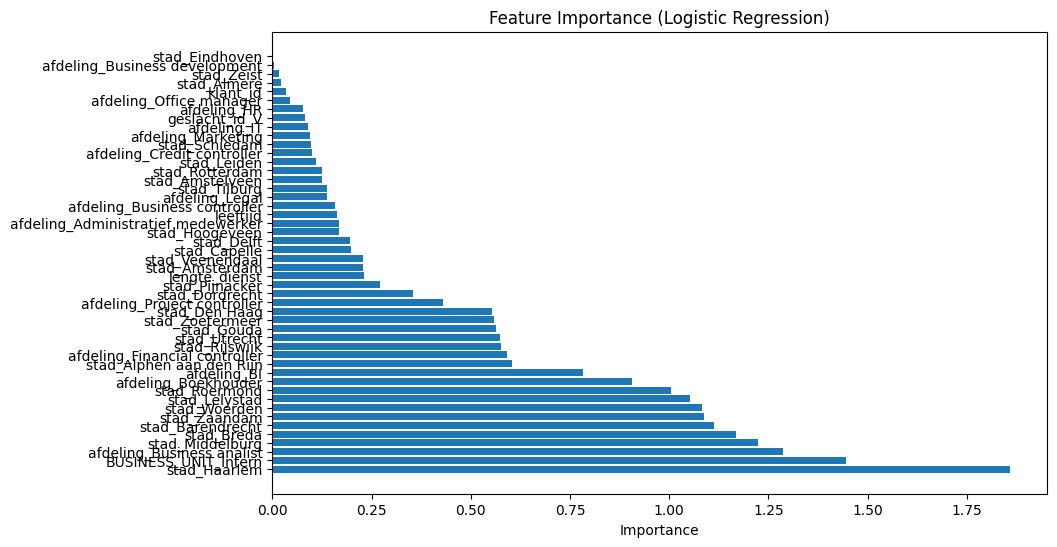

In [129]:
coefficients = model_lr.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Logistic Regression)')
plt.show()

In [130]:
saved_model_name = 'model_lr_TUNED.joblib'

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
}

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_lr_TUNED = loaded_model
else:
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    model_lr_TUNED = grid_search.best_estimator_
    joblib.dump(model_lr_TUNED, saved_model_name)

y_pred = model_lr_TUNED.predict(X_test)

train_score = model_lr_TUNED.score(X_train, y_train)
test_score = model_lr_TUNED.score(X_test, y_test)


model_scores['Logistic Regression TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Confusion Matrix:")
print(conf_matrix)
print(classification_report(y_test, y_pred))

Train Score: 0.7654664810025861
Test Score: 0.762132060461416
Confusion Matrix:
[[958   0]
 [299   0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.87       958
           1       0.00      0.00      0.00       299

    accuracy                           0.76      1257
   macro avg       0.38      0.50      0.43      1257
weighted avg       0.58      0.76      0.66      1257



c:\Users\Gamer\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gamer\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gamer\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [131]:
saved_model_name = 'model_HGBC.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_hgb = loaded_model

else:
    model_hgb = HistGradientBoostingClassifier()
    model_hgb.fit(X_train, y_train)
    joblib.dump(model_hgb, saved_model_name)


y_pred = model_hgb.predict(X_test)

train_score = model_hgb.score(X_train, y_train)
test_score = model_hgb.score(X_test, y_test)

model_scores['Hist Gradient Boosting'] = {
    'Train Score': train_score,
    'Test Score': test_score,
}

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print(classification_report(y_test, y_pred))

Train Score: 0.9045156156753531
Test Score: 0.9124900556881463
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       958
           1       0.99      0.64      0.78       299

    accuracy                           0.91      1257
   macro avg       0.95      0.82      0.86      1257
weighted avg       0.92      0.91      0.91      1257



In [132]:
saved_model_name = 'model_HGBC_TUNED.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_HGBC_TUNED = loaded_model
else:
    model_HGBC_TUNED = HistGradientBoostingClassifier()
    param_grid = {
        'max_iter': [100, 200,300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9, 21, 25],
        'min_samples_leaf': [1, 5, 10, 15, 20]
    }

    grid_search = GridSearchCV(estimator=model_HGBC_TUNED, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model_HGBC_TUNED = grid_search.best_estimator_
    joblib.dump(best_model_HGBC_TUNED, saved_model_name)
    print(f"Best Parameters: {grid_search.best_params_}")
    model_HGBC_TUNED = best_model_HGBC_TUNED


y_pred = model_HGBC_TUNED.predict(X_test)

train_score = model_HGBC_TUNED.score(X_train, y_train)
test_score = model_HGBC_TUNED.score(X_test, y_test)

model_scores['Hist Gradient Boosting TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
}

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

print(classification_report(y_test, y_pred))

Train Score: 0.9029242092699423
Test Score: 0.9108989657915673
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       958
           1       0.99      0.63      0.77       299

    accuracy                           0.91      1257
   macro avg       0.95      0.81      0.86      1257
weighted avg       0.92      0.91      0.90      1257



In [133]:
saved_model_name = 'model_KNN.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_knn = loaded_model
else:
    model_knn = KNeighborsClassifier()
    model_knn.fit(X_train, y_train)
    joblib.dump(model_knn, saved_model_name)

y_pred = model_knn.predict(X_test)

train_score = model_knn.score(X_train, y_train)
test_score = model_knn.score(X_test, y_test)

model_scores['KNN'] = {
    'Train Score': train_score,
    'Test Score': test_score,
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print(classification_report(y_test, y_pred))

Train Score: 0.8935746966381539
Test Score: 0.9053301511535402
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       958
           1       0.99      0.61      0.75       299

    accuracy                           0.91      1257
   macro avg       0.94      0.80      0.85      1257
weighted avg       0.92      0.91      0.90      1257



In [134]:

saved_model_name = 'model_KNN_TUNED.joblib'

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11]
}

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_knn_TUNED = loaded_model
else:
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    model_knn_TUNED = grid_search.best_estimator_
    print(f"Best Parameters: {grid_search.best_params_}")
    joblib.dump(model_knn_TUNED, saved_model_name)

y_pred = model_knn_TUNED.predict(X_test)

train_score = model_knn_TUNED.score(X_train, y_train)
test_score = model_knn_TUNED.score(X_test, y_test)


model_scores['KNN TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

print(classification_report(y_test, y_pred))
print(conf_matrix)

Train Score: 0.8935746966381539
Test Score: 0.9053301511535402
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       958
           1       0.99      0.61      0.75       299

    accuracy                           0.91      1257
   macro avg       0.94      0.80      0.85      1257
weighted avg       0.92      0.91      0.90      1257

[[957   1]
 [118 181]]


In [135]:
saved_model_name = 'model_XGBoost.joblib'


if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_xgboost = loaded_model
else:
    model_xgboost = XGBClassifier()
    model_xgboost.fit(X_train, y_train)
    print(f"Model Parameters: {model_xgboost.get_params()}")
    joblib.dump(model_xgboost, saved_model_name)

y_pred = model_xgboost.predict(X_test)

train_score = model_xgboost.score(X_train, y_train)
test_score = model_xgboost.score(X_test, y_test)


model_scores['XGBoost Classifier'] = {
    'Train Score': train_score,
    'Test Score': test_score,
}

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

print(classification_report(y_test, y_pred))

Train Score: 0.911279092898349
Test Score: 0.9220365950676214
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       958
           1       1.00      0.68      0.80       299

    accuracy                           0.92      1257
   macro avg       0.95      0.84      0.88      1257
weighted avg       0.93      0.92      0.92      1257



In [136]:
saved_model_name = 'model_XGBoost_TUNED.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_xgboost_TUNED = loaded_model
else:
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    model_xgboost_TUNED = grid_search.best_estimator_
    print(f"Model Parameters: {model_xgboost_TUNED.get_params()}")
    joblib.dump(model_xgboost_TUNED, saved_model_name)

y_pred = model_xgboost_TUNED.predict(X_test)

train_score = model_xgboost_TUNED.score(X_train, y_train)
test_score = model_xgboost_TUNED.score(X_test, y_test)


model_scores['XGBoost Classifier TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
}

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

print(classification_report(y_test, y_pred))

Train Score: 0.8935746966381539
Test Score: 0.9045346062052506
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       958
           1       0.99      0.60      0.75       299

    accuracy                           0.90      1257
   macro avg       0.94      0.80      0.85      1257
weighted avg       0.91      0.90      0.90      1257



In [137]:
saved_model_name = 'model_RandomForest.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_RF = loaded_model
else:
    model_RF = RandomForestClassifier(random_state=42)
    model_RF.fit(X_train, y_train)
    joblib.dump(model_RF, saved_model_name)

y_pred = model_RF.predict(X_test)

train_score = model_RF.score(X_train, y_train)
test_score = model_RF.score(X_test, y_test)


model_scores['Random Forest Classifier'] = {
    'Train Score': train_score,
    'Test Score': test_score
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(conf_matrix)



Train Score: 0.9313705987666601
Test Score: 0.9379474940334129
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       958
           1       1.00      0.74      0.85       299

    accuracy                           0.94      1257
   macro avg       0.96      0.87      0.91      1257
weighted avg       0.94      0.94      0.93      1257

Confusion Matrix:
[[957   1]
 [ 77 222]]


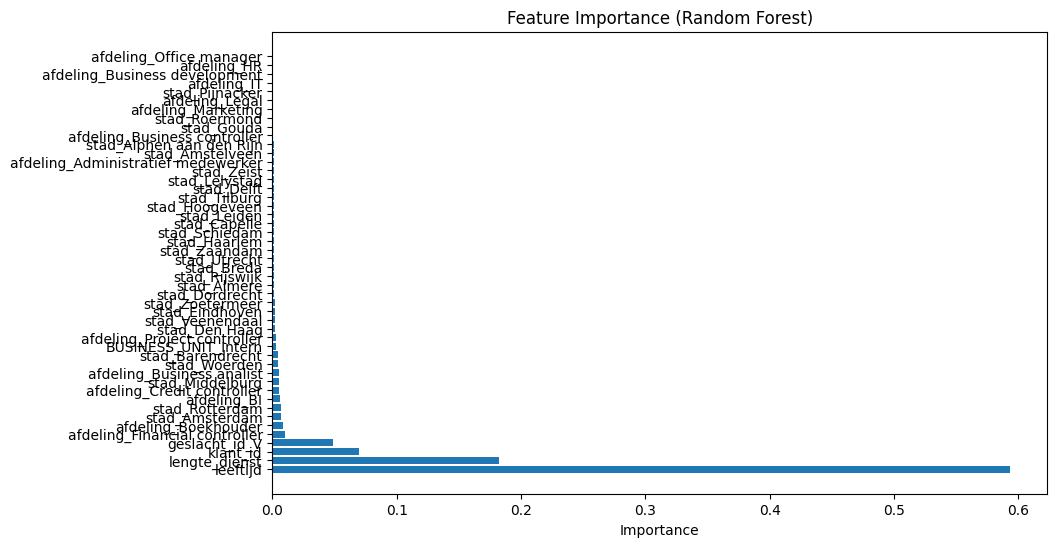

In [138]:
importances = model_RF.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

In [139]:
saved_model_name = 'model_RandomForest_TUNED.joblib'

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_RF_TUNED = loaded_model
else:
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    model_RF_TUNED = grid_search.best_estimator_
    joblib.dump(model_RF_TUNED, saved_model_name)

y_pred = model_RF_TUNED.predict(X_test)

train_score = model_RF_TUNED.score(X_train, y_train)
test_score = model_RF_TUNED.score(X_test, y_test)

model_scores['Random Forest Classifier TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score
}

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(conf_matrix)



Train Score: 0.899343544857768
Test Score: 0.9108989657915673
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       958
           1       0.99      0.63      0.77       299

    accuracy                           0.91      1257
   macro avg       0.95      0.81      0.86      1257
weighted avg       0.92      0.91      0.90      1257

Confusion Matrix:
[[957   1]
 [111 188]]


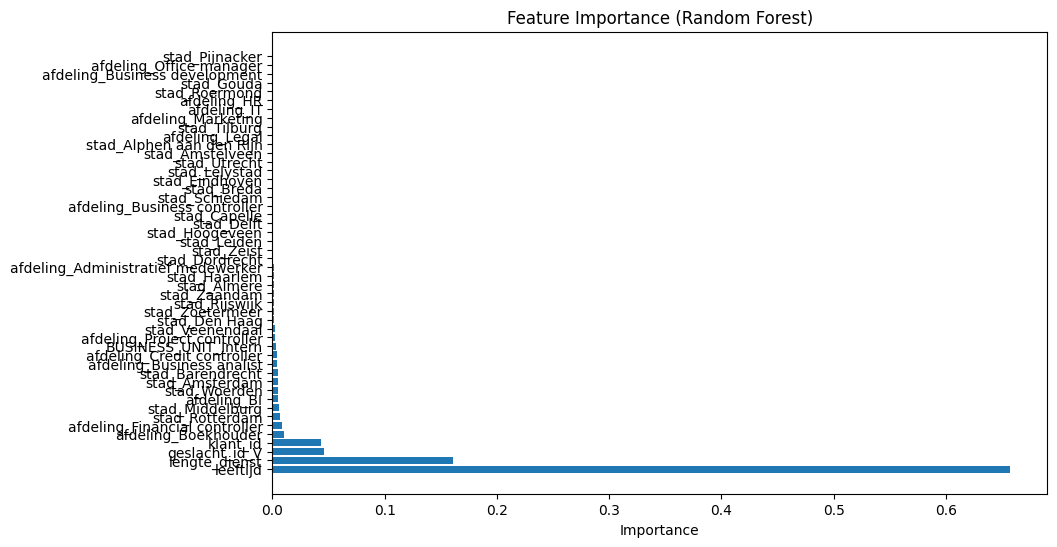

In [140]:
importances = model_RF_TUNED.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

In [141]:
model_KNN_D = KNN_D(dcalc = 'chebyshev')
model_KNN_D.fit(X_train, y_train)


y_train_pred = model_KNN_D.predict(X_train)
y_test_pred = model_KNN_D.predict(X_test)


train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)


model_scores['KNN_B'] = {
    'Train Score': train_score,
    'Test Score': test_score
}

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Train Score: 0.9427093694052119
Test Score: 0.9180588703261734
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       958
           1       0.99      0.63      0.77       299

    accuracy                           0.91      1257
   macro avg       0.95      0.81      0.86      1257
weighted avg       0.92      0.91      0.90      1257



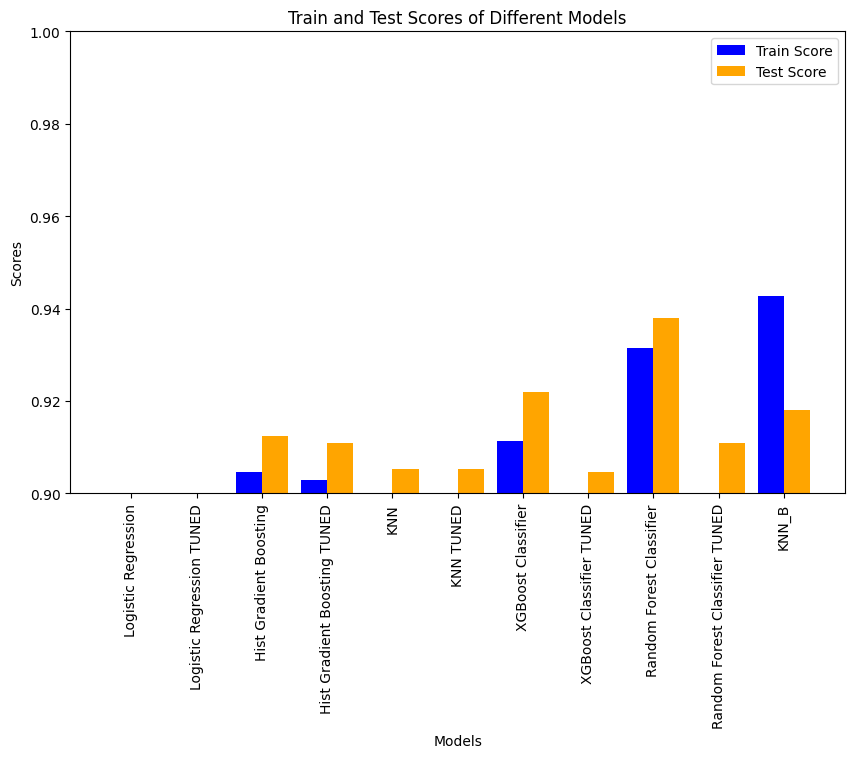

In [142]:
models = list(model_scores.keys())
train_scores = [model_scores[model]["Train Score"] for model in models]
test_scores = [model_scores[model]["Test Score"] for model in models]

x = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x, train_scores, width=0.4, label='Train Score', color='b', align='center')
plt.bar([p + 0.4 for p in x], test_scores, width=0.4, label='Test Score', color='orange', align='center')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Train and Test Scores of Different Models')
plt.xticks([p + 0.2 for p in x], models , rotation =90)
plt.ylim(0.9, 1)
plt.legend()
plt.show()


Find at employees at risk of leaving.

In [143]:
X = df_with_dummies.drop('STATUS_Beëindigd', axis=1)
y = df_with_dummies['STATUS_Beëindigd']

model = RandomForestClassifier()
kf = KFold(n_splits=10)

predicted_vals = []

for i, j in kf.split(X):
    X_train, X_test = X.iloc[i], X.iloc[j]
    y_train, y_test = y.iloc[i], y.iloc[j]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predicted_vals.extend(predictions)

df_n_dummies = pd.get_dummies(df , columns=['STATUS'] , drop_first=True)
df['pred_STATUS_Beëindigd'] = predicted_vals

at_risk_employees = df_n_dummies[(df_n_dummies['pred_STATUS_Beëindigd'] == True) & (df_n_dummies['STATUS_Beëindigd'] == False)]
at_risk_employees


ValueError: Length of values (6284) does not match length of index (49753)